In [12]:
import numpy as np
from tqdm.notebook import tqdm, trange
from alive_progress import alive_bar
import time # to be used in loop iterations
np.random.seed(1234)

In [36]:
import time
with alive_bar(100, force_tty=True) as bar:
    for i in range(100):
        time.sleep(0.001)
        bar()

|████████████████████████████████████████| 100/100 [100%] in 0.1s (788.80/s)    


In [30]:
#Ground truth data distribution
def random_sample(d, Delta, N):
    y = np.random.randint(0,2,N)
    np.where(y==0, -1, y)
    x = np.zeros((N,d))
    for i in range(N):
        if y[i] == 1:
            x[i,:] = np.random.multivariate_normal([0]*d, np.diag([(1+Delta)**2]*d))
        if y[i] == -1:
            x[i,:] = np.random.multivariate_normal([0]*d, np.diag([(1-Delta)**2]*d))
    return x.reshape(N,d),y

In [13]:
#activation function
def sigma(t, t1, s1, t2, s2):
    if t < t1:
        return s1
    elif t>t2:
        return s2
    else:
        return (s2-s1)/(t2-t1)*(t-t1)+s1
    
def grad_sigma(t, t1, s1, t2, s2):
    if t < t1:
        return 0
    elif t>t2:
        return 0
    else:
        return (s2-s1)/(t2-t1)
vgrad_sigma = np.vectorize(grad_sigma)
vsigma = np.vectorize(sigma)

In [14]:
#two layer neural net
def neural_net(x, θ):
    out = vsigma(θ@x, 0.5, -2.5, 1.5, 7.5)
    return np.mean(out)

In [37]:
def stochastic_gradient_descent(weights, d, Delta, N, ϵ = 1e-6, num_epochs = 1000):
    
    with alive_bar(num_epochs, force_tty=True) as bar:
        for epoch in range(num_epochs): 
            # Update the weights
            sample = random_sample(d,Delta,1)
            X = sample[0].reshape(d,1)
            y = sample[1]
            vgrad = vgrad_sigma(weights@X, 0.5, -2.5, 1.5, 7.5)
            gradient = vgrad_sigma(weights@X, 0.5, -2.5, 1.5, 7.5).reshape(N,1)*(X).reshape(1,d)
            weights += 2*ϵ*(y-neural_net(X, weights))*gradient
            bar()
                
    return weights


In [ ]:
#params
d = 4
N = 8
Delta = 0.8

# Initialize random weights

weights = np.random.multivariate_normal([0]*d, np.diag([(Delta)**2/d]*d), N).reshape(N, d)

weights = stochastic_gradient_descent(weights, d, Delta, N, ϵ = 1e-6, num_epochs = int(1e7))

|████▌                                   | ▂▄▆ 1124010/10000000 [11%] in 5:29 (~ ▆█▆ 526888/10000000 [5%] in 2:17 (~41 ▂▂▄ 704901/10000000 [7%] in 3:00 (~39 ▂▄▆ 771990/10000000 [8%] in 3:28 (~41 ▃▅▇ 975065/10000000 [10%] in 4:46 (~4 ▄▆█ 1006592/10000000 [10%] in 4:54 (~ ▆▄▂ 1091523/10000000 [11%] in 5:19 (~

In [7]:
weights_norms = [np.linalg.norm(weights[i,:]) for i in range(weights.shape[0])]

(array([1.24927285, 1.56159106, 3.74781855, 7.49563709, 4.9970914 ,
        5.93404603, 3.74781855, 1.24927285, 0.31231821, 0.93695464]),
 array([1.31668039, 1.34869902, 1.38071765, 1.41273627, 1.4447549 ,
        1.47677352, 1.50879215, 1.54081078, 1.5728294 , 1.60484803,
        1.63686665]),
 <BarContainer object of 10 artists>)

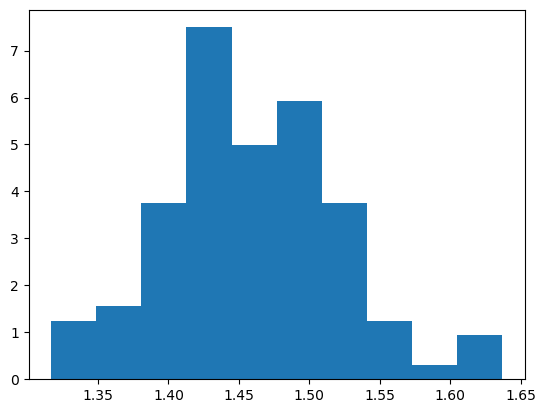

In [8]:
import matplotlib.pyplot as plt 
plt.hist(weights_norms, density = True)

In [ ]:
sample = random_sample(40, 0.8, 1)
x = sample[0][0]
y = sample[1]
neural_net(x, weights)

In [ ]:
from scipy.stats import norm

def q_plus(t, Delta):
    x = np.linspace(-10, 10, 100)
    f = 1 / (np.sqrt(2 * np.pi)) * vsigma((1 + Delta) * t * x, 0.5, -2.5, 1.5, 7.5) * np.exp(-x ** 2 / 2)
    integral = np.trapz(f, x)
    return integral

def q_minus(t, Delta):
    x = np.linspace(-10,10, 100)
    f = 1 / (np.sqrt(2 * np.pi)) * vsigma((1 - Delta) * t * x, 0.5, -2.5, 1.5, 7.5) * np.exp(-x ** 2 / 2)
    integral = np.trapz(f, x)
    return integral

vq_plus = np.vectorize(q_plus)
vq_minus = np.vectorize(q_minus)

def R_inf(r, vq_plus, vq_minus, Delta):
    mean_vq_plus = np.mean(vq_plus)
    mean_vq_minus = np.mean(vq_minus)
    return 0.5 * (1 - mean_vq_plus) ** 2 + 0.5 * (1 + mean_vq_minus) ** 2

def grad_R_inf(r, vq_plus, vq_minus, Delta):
    J = len(r)
    mean_vq_plus = np.mean(vq_plus)
    mean_vq_minus = np.mean(vq_minus)
    return -1 / J * vq_plus * (1 - mean_vq_plus) + 1 / J * vq_minus * (1 + mean_vq_minus)

def update(r, dt, grad):
    J = len(r)
    return r - J * grad * dt

In [ ]:
#simulate pde
Interval = 10**np.linspace(-1e-5,1, int(1e4))
J = 100
pde_vals = np.zeros((100,J))
Delta = 0.8
d = 40
separations = [Interval[k+1]-Interval[k] for k in range(len(Interval)-1)]

In [ ]:
#simulate 100 times and obtain a histogram
for i in trange(1):
    Z = np.random.multivariate_normal([0]*d, np.diag([(Delta)**2/d]*d), J).reshape(J, d)
    r = np.linalg.norm(Z, axis = 1)
    for dt in tqdm(separations):
        plus = vq_plus(r, Delta)
        minus = vq_minus(r, Delta)
        r = update(r,dt, grad_R_inf(r, plus, minus, Delta))
    pde_vals[i] = r
    print(pde_vals)

In [ ]:
import matplotlib.pyplot as plt
plt.hist(np.ndarray.flatten(pde_vals), density = True)

In [ ]:
np.ndarray.flatten(pde_vals)